### This is Example 4.3. Gambler’s Problem from Sutton's book.

A gambler has the opportunity to make bets on the outcomes of a sequence of coin flips. 
If the coin comes up heads, he wins as many dollars as he has staked on that flip; 
if it is tails, he loses his stake. The game ends when the gambler wins by reaching his goal of $100, 
or loses by running out of money. 

On each flip, the gambler must decide what portion of his capital to stake, in integer numbers of dollars. 
This problem can be formulated as an undiscounted, episodic, finite MDP. 

The state is the gambler’s capital, s ∈ {1, 2, . . . , 99}.
The actions are stakes, a ∈ {0, 1, . . . , min(s, 100 − s)}. 
The reward is zero on all transitions except those on which the gambler reaches his goal, when it is +1.

The state-value function then gives the probability of winning from each state. A policy is a mapping from levels of capital to stakes. The optimal policy maximizes the probability of reaching the goal. Let p_h denote the probability of the coin coming up heads. If p_h is known, then the entire problem is known and it can be solved, for instance, by value iteration.


In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
if "../" not in sys.path:
  sys.path.append("../") 


### Exercise 4.9 (programming)

Implement value iteration for the gambler’s problem and solve it for p_h = 0.25 and p_h = 0.55.



We define a helper function, argmax, which will return the index of the highest-valued element of a numpy array, with any ties broken randomly.

In [2]:
def argmax(b):
    """
    Tie-breaking argmax function.
    
    Args:
        b: numpy array of shape (X,).
        
    Returns:
        Index of the highest-valued element of b, with ties broken randomly.
    """
    return np.random.choice(np.where(b == b.max())[0])

We also define a get_stake function, which will take the policy, and output the stakes corresponding to each capital state

In [3]:
def get_stake(policy):
    """
    Takes the policy and outputs the stake corresponding to each state.
    
    Args:
        policy: optimal policy.
        
    Returns:
        The stake corresponding to each state, as a list.
    """
    policy_stake = []
    for state in policy:
        for element in state.tolist():
            if element > 0:
                policy_stake.append(state.tolist().index(element))
    return policy_stake

In [4]:
def value_iteration_for_gamblers(p_h, theta=0.0001, discount_factor=1.0):
    """
    Args:
        p_h: Probability of the coin coming up heads.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    """
    
    def one_step_lookahead(s, V, rewards):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            s: The state to consider (int)
            V: The vector that contains values at each state. 
            rewards: The reward vector.
                        
        Returns:
            A vector containing the expected value of each action. 
            Its length equals to the number of actions.
        """
        
        # Define an empty vector of size min(s, 100 - s) + 1
        # The number of possible actions for each state includes 
        # doing nothing, hence the '+1'
        A = np.zeros(min(s, 100 - s) + 1)
        # Iterate over the actions in each state
        for action in range(min(s, 100 - s) + 1):
            # This case applies specifically when
            # s = 50 and action = 50 and will put the gambler into terminal states
            if s + action == 100 and s - action == 0:
                state_plus_action = 0
                state_minus_action = 0
            # This case applies when the action will result
            # in a new capital of 100
            elif s + action == 100:
                state_plus_action = 0
                state_minus_action = V[s - action]
            # This case applies when the action will result
            # in a new capital of 0
            elif s - action == 0:
                state_plus_action = V[s + action]
                state_minus_action = 0
            # In all other cases
            else:
                state_plus_action = V[s + action]
                state_minus_action = V[s - action]

            A[action] = (p_h * (rewards[s][action] + discount_factor * state_plus_action) 
                         + (1 - p_h) * (0 + state_minus_action))
        
        return A
    
    
    # Initialize the state-value vector with zeros. The vector is of size 100, 
    # corresponding to states 0, 1, 2, ..., 99. However, because capital of state
    # 0 is not supposed to exist we will remove it right before returning the vector
    V = np.zeros(100)
    
    # We initialize the rewards vector. This will define the results for each state
    # and depending on what action was taken
    rewards = {}
    # Initialize the dictionary shape
    for state in range(1, 100):
        rewards[state] = {action: [] for action in range(min(state, 100 - state) + 1)}
    # Populate every state from 1 to 99 with rewards
    for state in range(1, 100):
        for action in range(min(state, 100 - state) + 1):
            # Rewards are 0 for most state-action combinations
            reward = 0
            # When the action will put the state at 100 total capital
            # The reward has to be +1
            if state + action == 100:
                reward = 1
            rewards[state][action] = reward
    
    # Value iteration with taking the highest action-value in each state
    while True:
        # Initialize delta
        delta = 0
        # Update each state...
        for s in range(1, 100):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V, rewards)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value        
        # Check if we can stop 
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    # Initialize the policy with zeros to update it
    policy = np.zeros([100, 51])
    for s in range(1, 100):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V, rewards)
        # Use the tie-breaking argmax function to ensure
        # first-highest result is not always selected
        best_action = argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0
    
    # Take our the un-updated state '0'
    V = V[1:]
    policy = policy[1:]
    
    return policy, V

### Example policy and value function for p_h = 0.25

In [5]:
policy, v = value_iteration_for_gamblers(0.25)

print("Optimized Policy:")
print("Policy shape: ", policy.shape)
print('\n')
print(policy)
print("")

print("Optimized Value Function:")
print("Optimized Value Function shape: ", v.shape)
print('\n')
print(v)
print("")

Optimized Policy:
Policy shape:  (99, 51)


[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]

Optimized Value Function:
Optimized Value Function shape:  (99,)


[7.24792480e-05 2.89916992e-04 6.95257448e-04 1.16010383e-03
 1.76906586e-03 2.78102979e-03 4.03504074e-03 4.66214120e-03
 5.59997559e-03 7.08471239e-03 9.03964043e-03 1.11241192e-02
 1.56793594e-02 1.61464431e-02 1.69517994e-02 1.86512806e-02
 1.98249817e-02 2.24047303e-02 2.73845196e-02 2.83388495e-02
 3.04937363e-02 3.61633897e-02 3.84953022e-02 4.44964767e-02
 6.25000000e-02 6.27174377e-02 6.33700779e-02 6.45857723e-02
 6.59966059e-02 6.78135343e-02 7.08430894e-02 7.46098323e-02
 7.64884604e-02 7.93035477e-02 8.37541372e-02 8.96225423e-02
 9.58723575e-02 1.09538078e-01 1.10939329e-01 1.13360151e-01
 1.18457374e-01 1.21977661e-01 1.29716907e-01 1.44653559e-01
 1.47520113e-01 1.53983246e-01 1.70990169e-01 1.77987434e-01


### Print the Most-Common Policy for p_h = 0.4

Run the 'value_iteration_for_gamblers' function 1000 times and find out which action appeared for each state most often. Then plot the stake for each state.

In [6]:
!pip install tqdm

You should consider upgrading via the 'c:\users\midav\anaconda3\python.exe -m pip install --upgrade pip' command.


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:36<00:00,  6.38it/s]


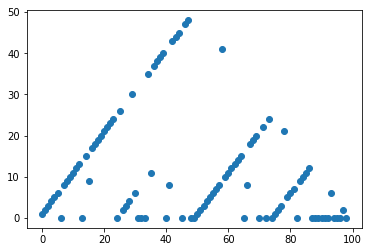

In [7]:
from tqdm import tqdm
RUN_TIMES = 1000
prob_heads = 0.4
policy_shape = (99, 51)
most_common_counts = np.zeros(policy_shape)
for _ in tqdm(range(RUN_TIMES), ncols = 120):
    policy, _ = value_iteration_for_gamblers(prob_heads)
    for ii, row in enumerate(policy):
        col = int(np.where(row == 1)[0])
        most_common_counts[ii][col] += 1
most_common_policy = np.zeros(policy_shape)
for jj, row in enumerate(most_common_counts):
    col = int(np.where(max(row) == row)[0][0])
    most_common_policy[jj][col] = 1
policy_stake = get_stake(most_common_policy)
plt.scatter(range(len(policy_stake)), policy_stake);

### Policy Stake Plots

Iterate over p_h = 0.25, 0.55. Then iterate over decreasing thetas with theta = 0.0001, 0.00001, 0.000001.

In [8]:
p_hs = [0.25, 0.55]
thetas = [0.0001, 0.00001, 0.000001]

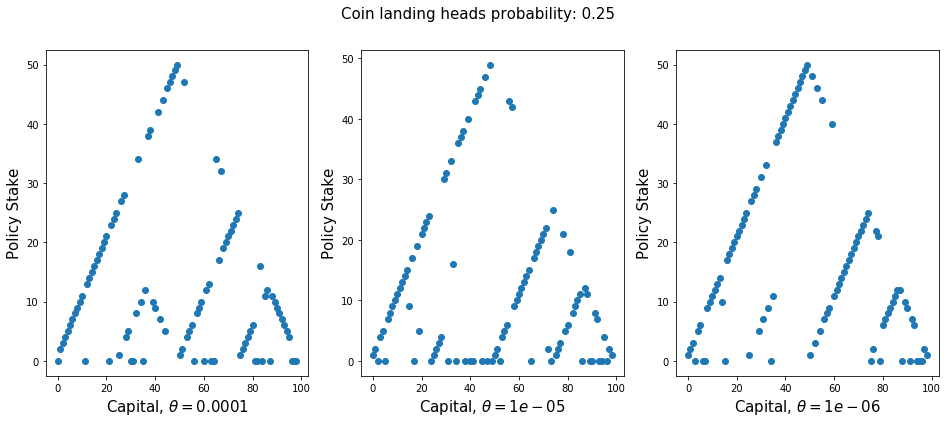

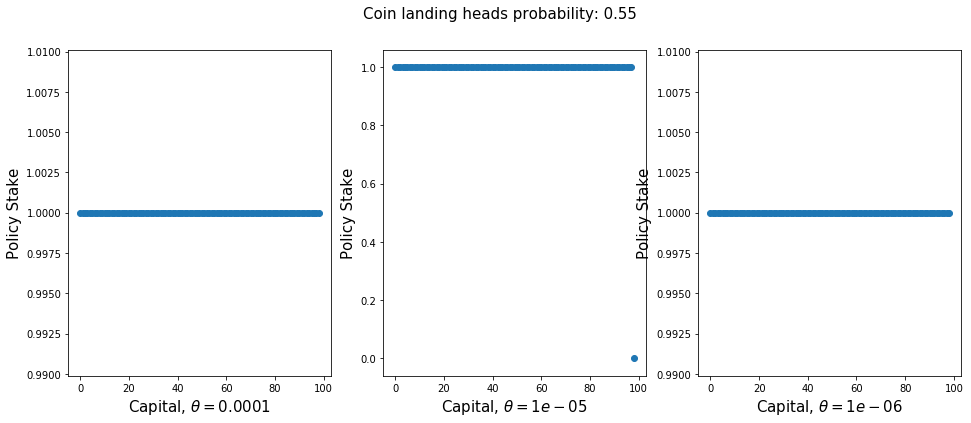

In [9]:
for i, p_h in enumerate(p_hs):
    plt.figure(figsize=(16, 6))
    plt.suptitle("Coin landing heads probability: " +  str(p_h), fontsize = 15)
    for j, theta in enumerate(thetas):
        policy, _ = value_iteration_for_gamblers(p_h, theta = theta)
        policy_stake = get_stake(policy)
        plt.subplot(130 + j + 1)
        plt.scatter(range(len(policy_stake)), policy_stake)
        #plt.bar(range(len(policy_stake)), policy_stake)
        plt.xlabel('Capital, ' + r'$\theta = ' + str(theta) + '$', fontsize = 15)
        plt.ylabel('Policy Stake', fontsize = 15)
plt.show()

### Value Function Plots

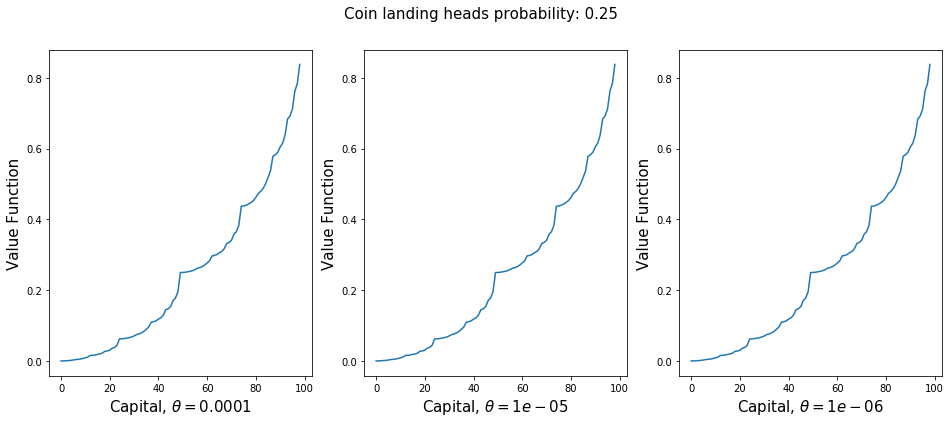

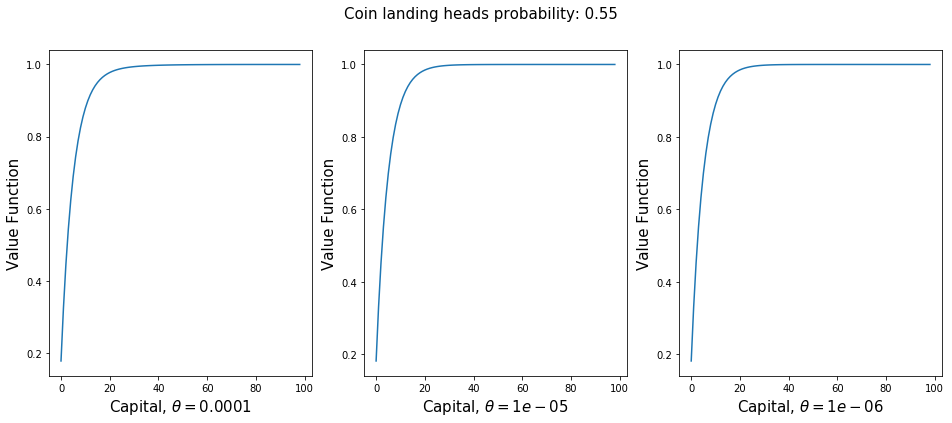

In [10]:
for i, p_h in enumerate(p_hs):
    plt.figure(figsize=(16, 6))
    plt.suptitle("Coin landing heads probability: " +  str(p_h), fontsize = 15)
    for j, theta in enumerate(thetas):
        _, v = value_iteration_for_gamblers(p_h, theta = theta)
        policy_stake = get_stake(policy)
        plt.subplot(130 + j + 1)
        plt.plot(range(v.shape[0]), v)
        plt.xlabel('Capital, ' + r'$\theta = ' + str(theta) + '$', fontsize = 15)
        plt.ylabel('Value Function', fontsize = 15)
plt.show()

## Question:

Why does the optimal policy for the gambler’s problem have such a curious form? In particular, for capital of 50 it bets it all on one flip, but for capital of 51 it does not. Why is this a good policy? Are the results stable as $\theta$ approaches 0?

While decreasing $\theta$, the results for both p_h = 0.25 and p_h = 0.55 appear to retain the same shape and appear to be stable. The overall shape of the optimal policy for p_h = 0.25 changes slightly but appears to retain a similar shape. For p_h = 0.55 at every capital level the policy to bet 1 dollar remains the same. Intuitively, because the gamblers goal is to reach 100 dollars, but no more, it makes sense to bet the entire 50 dollar amount of capital when the gambler has 50 dollars. However, when the gambler has more than 50 dollars, it makes sense to decrease the bet to avoid losing the entire capital. The general shape of the policy stake vs capital will increase at first follows by a decrease. Looking at the one-step lookahead formula, we begin updating the states starting with 1 and increasing. It then appears that between states 1 - 50, state 50 with action of betting 50 dollars will earn the highest reward and will produce the highest action-value. However when we update states 51-99, less than 49 dollars will not produce the desired reward of 100 dollars, and therefore actions betting dollar amount that will produce 100 dollars will receive higher rewards. It makes sense then that the policy stakes drop significantly at the capital of 51 dollars.